# Generator ročno napisanih števk

Naloga zajema diskriminatorske nevronske mreže, ki poizkušajo prepoznati, ali je slika realna ali generirana in generativne nevronske mreže, ki poizkušajo generirati sliko, ki bi pretentala diskriminatorsko nevronsko mrežo

## 1. Predstavitev pomožnih funkcij

V spodnjem odseku so vsi uporabljeni uvoženi paketi, knjižnice in globalne spremenljivke.

Testne slike se avtomatsko pridobijo, uporabljena pa je podatkovna zbirka MNIST.

Za učenje nevronske mreže so bili uporabljeni sledeči parametri:
* Epochs: 100
* Batch size: 256
* Learning rate: 0.0002
* Optimizacijski algoritem: Adam
* Metrika izgube: BCE
* Beta 1 - Generator: 0.5
* Beta 2 - Generator: 0.999
* Beta 1 - Diskriminator: 0.5
* Beta 2 - Diskriminator: 0.999

Nevronska mreža se je učila na grafični kartici.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cv2
import os
import torch
import torchvision
import torchinfo
import skimage
import random

from torch.utils.data import Dataset, DataLoader

EPOCHS = 100
BATCH_SIZE = 256
LR = 2e-4

DISCRIMINATOR_BETA1 = 0.5
DISCRIMINATOR_BETA2 = 0.999

GENERATOR_BETA1 = 0.5
GENERATOR_BETA2 = 0.999

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"Device: {device}")

Device: cuda


Spodaj je definiran razred za dataset, s katerim se lahko uporablja `BATCH_SIZE`.

In [2]:
class ImageDataset(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.Y[index]

Sledi model nevronske mreže za diskriminator, ki je sestavljen na sledeč način:
* `Conv2D`, konvolucija, ki ima 1 vhoden kanal in 64 izhodnih ter velikost filtra `(3, 3)`, premik `(2, 2)` in padding `(1, 1)`,
* `BatchNorm2d`, sledi batch normalization sloj,
* `LeakyReLU`, LeakyReLU aktivacijska funkcija z naklonom 0.2 v negativnem delu,
* `Conv2D`, konvolucija, ki ima 64 vhodnih kanalov in 64 izhodnih ter velikost filtra `(3, 3)`, premik `(2, 2)` in padding `(1, 1)`,
* `BatchNorm2d`, sledi batch normalization sloj,
* `LeakyReLU`, LeakyReLU aktivacijska funkcija z naklonom 0.2 v negativnem delu,
* `Flatten`, sloj, ki pretvori tenzor v eno-dimenzionalnega
* `Linear`, linearna transformacija,
* `Sigmoid`, sigmoidna aktivacijska funkcija.

In [3]:
class Discriminator(torch.nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.first_conv2d = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    self.second_conv2d = torch.nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    self.first_batchnorm2d = torch.nn.BatchNorm2d(64)
    self.second_batchnorm2d = torch.nn.BatchNorm2d(64)
    self.leakyrelu = torch.nn.LeakyReLU(0.2)
    self.flatten = torch.nn.Flatten()
    self.linear = torch.nn.Linear(3136, 1)
    self.sigmoid = torch.nn.Sigmoid()

  def forward(self, x):
    x = self.first_conv2d(x)
    x = self.first_batchnorm2d(x)
    x = self.leakyrelu(x)
    x = self.second_conv2d(x)
    x = self.second_batchnorm2d(x)
    x = self.leakyrelu(x)
    x = self.flatten(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    return x

In še model nevronske mreže za generator, ki je sestavljen na sledeč način:
* `Linear`, linearna transformacija,
* `ReLU`, ReLU aktivacijska funkcija,
* `Reshape`, preobrazba nevrona v obliko `(-1, 128, 7, 7)`
* `ConvTranspose2D`, konvolucija, ki ima 128 vhodnih kanalov in 128 izhodnih ter velikost filtra `(4, 4)`, premik `(2, 2)` in padding `(1, 1)`,
* `BatchNorm2d`, sledi batch normalization sloj,
* `ReLU`, ReLU aktivacijska funkcija,
* `ConvTranspose2D`, konvolucija, ki ima 128 vhodnih kanalov in 128 izhodnih ter velikost filtra `(4, 4)`, premik `(2, 2)` in padding `(1, 1)`,
* `BatchNorm2d`, sledi batch normalization sloj,
* `ReLU`, ReLU aktivacijska funkcija,
* `Conv2D`, konvolucija, ki ima 128 vhodnih kanalov in enega izhodnega ter velikost filtra `(7, 7)`, premik `(1, 1)` in padding `(3, 3)`,
* `Sigmoid`, sigmoidna aktivacijska funkcija.

In [4]:
class Generator(torch.nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.linear = torch.nn.Linear(100, 6272)
    self.relu = torch.nn.ReLU()
    self.first_convtranspose2d = torch.nn.ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    self.second_convtranspose2d = torch.nn.ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    self.first_batchnorm2d = torch.nn.BatchNorm2d(128)
    self.second_batchnorm2d = torch.nn.BatchNorm2d(128)
    self.conv2d = torch.nn.Conv2d(128, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    self.sigmoid = torch.nn.Sigmoid()

  def forward(self, x):
    x = self.linear(x)
    x = self.relu(x)
    x = torch.reshape(x, (-1, 128, 7, 7))
    x = self.first_convtranspose2d(x)
    x = self.first_batchnorm2d(x)
    x = self.relu(x)
    x = self.second_convtranspose2d(x)
    x = self.second_batchnorm2d(x)
    x = self.relu(x)
    x = self.conv2d(x)
    x = self.sigmoid(x)
    return x

Funkcija za prikaz slike z napisom.

In [5]:
def display_image(image, title, cmap="viridis"):
  plt.imshow(image, cmap=cmap)
  plt.title(title)
  plt.axis('off')
  plt.show()

Sliko je potrebno pretvoriti na interval `[0, 1]`, porezati vrednosti izven tega intervala ter spremeniti podatkovni tip v `float32`, kar pa stori funkcija spodaj.

In [6]:
def fix_image(image):
  image = image / 255
  image[image > 1] = 1
  image[image < 0] = 0
  image = image.astype(np.float32)
  return image

Slike morajo prav tako biti v formatu tenzorja `[batch size, channels, height, width]`, kar pa stori spodnja funkcija.

In [7]:
def expand(images):
  images = images[..., np.newaxis]
  images = images.transpose((0, 3, 1, 2))

  return images

Naslednja funkcija izpiše podatke o zbirki slik.

In [8]:
def print_dataset_info(images, labels = None):
  print("==================================")
  print("PODATKI O ZBIRKI SLIK")
  print("==================================")
  print("IME ZBIRKE: MNIST")
  print(f"ŠTEVILO SLIK: {images.shape[0]}")
  print(f"ŠIRINA SLIK: {images.shape[1]}")
  print(f"VIŠINA SLIK: {images.shape[2]}")
  print("ŠTEVILO KANALOV SLIK: 1")
  print("PRIMERI SLIK:")

  plt.figure(figsize=(10, 10))
  for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.axis("off")
    
    if type(labels) is np.ndarray:
      plt.title(labels[i])
      
    plt.tight_layout()
    
  print("==================================")

## 2. Učenje nevronskih mrež

Parametri za učenje so že bili opisani v poglavju 1.

Učenje poteka po naslednjih korakh:
* inicializacija dataseta, ki je velikosti `BATCH_SIZE / 2`, saj prvo polovico sestavljajo realne slike, drugo polovico pa generirane slike,
* inicializacija izhodov nevronskih mrež, kar pa je vektor enic ali ničel velikosti `BATCH_SIZE / 2`,
* sledi učenje `EPOCH` epoh,
  * **DISKRIMINATOR:**
    * gradienti **diskriminatorja** so postavljeni na 0,
    * vhod v **diskriminator** je `BATCH_SIZE / 2` naključnih slik zbirke MNIST,
    * izračuna se napaka med izhodnimi vrednostmi in vektorjem enic velikosti `BATCH_SIZE / 2`,
    * izračun gradientov,
    * vhod v **generator** je `BATCH_SIZE / 2` vektorjev dolžine 100 z normalno porazdeljenimi vrednostmi,
    * izhodne vrednosti generatorja so uporabljene kot vhodne vrednosti **diskriminatorja**,
    * izračuna se napaka med izhodnimi vrednostmi in vektorjem **ničel** velikosti `BATCH_SIZE / 2`,
    * izračun gradientov,
    * posodabljanje uteži diskriminatorja.
  * **GENERATOR:**
    * gradienti **generatorja** so postavljeni na 0,
    * vhod v **generator** je `BATCH_SIZE / 2` vektorjev dolžine 100 z normalno porazdeljenimi vrednostmi,
    * izhodne vrednosti generatorja so uporabljene kot vhodne vrednosti **diskriminatorja**,
    * izračuna se napaka med izhodnimi vrednostmi in vektorjem **enic** velikosti `BATCH_SIZE / 2`,
    * izračun gradientov,
    * posodabljanje uteži generatorja.
  * za namene testiranja, se vsakih 10 epoh shrani model **generatorja**.


In [9]:
def train(discriminator, generator, images):
  discriminator = discriminator.to(device)
  generator = generator.to(device)

  discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=LR, betas=(DISCRIMINATOR_BETA1, DISCRIMINATOR_BETA2))
  generator_optimizer = torch.optim.Adam(generator.parameters(), lr=LR, betas=(GENERATOR_BETA1, GENERATOR_BETA2))

  discriminator_loss_fn = torch.nn.BCELoss()
  generator_loss_fn = torch.nn.BCELoss()
  
  discriminator.train()
  generator.train()
      
  dataset = ImageDataset(images, images)
  dataloader = DataLoader(dataset=dataset, batch_size=int(BATCH_SIZE / 2), shuffle=True)

  first_target = torch.from_numpy(np.ones((int(BATCH_SIZE / 2), 1), dtype=np.float32)).to(device)
  second_target = torch.from_numpy(np.zeros((int(BATCH_SIZE / 2), 1), dtype=np.float32)).to(device)

  for epoch in range(EPOCHS):
    print(f"TRAINING EPOCH {epoch + 1} OF {EPOCHS}")
    
    for step, (input_batch, _) in enumerate(dataloader):
      input_batch = input_batch.to(device)

      discriminator_optimizer.zero_grad()
      pred = discriminator(input_batch)
      loss = discriminator_loss_fn(pred, first_target)
      loss.backward()
      
      inputs = torch.from_numpy(np.random.normal(size=(int(BATCH_SIZE / 2), 100)).astype(np.float32)).to(device)
      outputs = generator(inputs)
      pred = discriminator(outputs)
      loss = discriminator_loss_fn(pred, second_target)
      loss.backward()

      discriminator_optimizer.step()

      generator_optimizer.zero_grad()
      inputs = torch.from_numpy(np.random.normal(size=(int(BATCH_SIZE / 2), 100)).astype(np.float32)).to(device)
      outputs = generator(inputs)
      pred = discriminator(outputs)
      loss = generator_loss_fn(pred, first_target)
      loss.backward()

      generator_optimizer.step()

    if epoch == 0 or (epoch + 1) % 10 == 0:
      print(f'SAVING TO generator{epoch + 1}.pt')
      torch.save(generator, f"generator{epoch + 1}.pt")

  torch.save(discriminator, f"discriminator{EPOCHS}.pt")

## 3. Nalaganje in prikazovanje slik

Naložijo se slike iz zbirke slik MNIST, skupaj z njihovimi dejanskimi vrednostmi pa se jih prikaže prvih 25, po prikazu pa se ustrezno pretvorijo v format za `pytorch`.

PODATKI O ZBIRKI SLIK
IME ZBIRKE: MNIST
ŠTEVILO SLIK: 59904
ŠIRINA SLIK: 28
VIŠINA SLIK: 28
ŠTEVILO KANALOV SLIK: 1
PRIMERI SLIK:


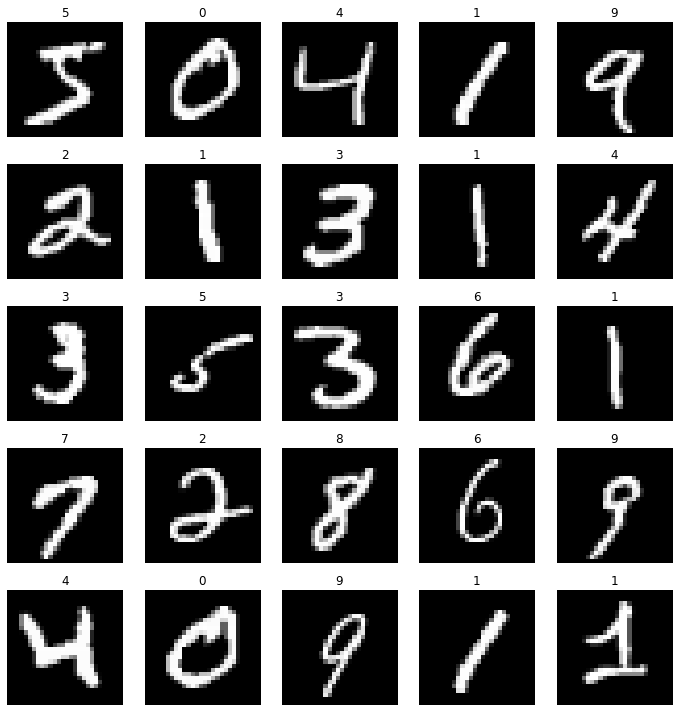

In [10]:
dataset = torchvision.datasets.MNIST("datasets", download=True)

images = np.array([fix_image(np.array(el[0])) for el in dataset])[:59904]
labels = np.array([el[1] for el in dataset])[:25]

print_dataset_info(images, labels)
images = expand(images)

Inicializacija modelov generatorja in diskriminatorja.

In [11]:
discriminator = Discriminator()
generator = Generator()

## 4. Prikaz informacij nevronskih mrež

Spodaj so zapisane informacije diskriminatorja.

In [12]:
print(torchinfo.summary(discriminator, (128, 1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [128, 1]                  --
├─Conv2d: 1-1                            [128, 64, 14, 14]         640
├─BatchNorm2d: 1-2                       [128, 64, 14, 14]         128
├─LeakyReLU: 1-3                         [128, 64, 14, 14]         --
├─Conv2d: 1-4                            [128, 64, 7, 7]           36,928
├─BatchNorm2d: 1-5                       [128, 64, 7, 7]           128
├─LeakyReLU: 1-6                         [128, 64, 7, 7]           --
├─Flatten: 1-7                           [128, 3136]               --
├─Linear: 1-8                            [128, 1]                  3,137
├─Sigmoid: 1-9                           [128, 1]                  --
Total params: 40,961
Trainable params: 40,961
Non-trainable params: 0
Total mult-adds (M): 248.10
Input size (MB): 0.40
Forward/backward pass size (MB): 32.11
Params size (MB): 0.16
Estimated Total Size (MB): 32.68


Sledijo pa še informacije generatorja.

In [13]:
print(torchinfo.summary(generator, (1, 100)))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 1, 28, 28]            --
├─Linear: 1-1                            [1, 6272]                 633,472
├─ReLU: 1-2                              [1, 6272]                 --
├─ConvTranspose2d: 1-3                   [1, 128, 14, 14]          262,272
├─BatchNorm2d: 1-4                       [1, 128, 14, 14]          256
├─ReLU: 1-5                              [1, 128, 14, 14]          --
├─ConvTranspose2d: 1-6                   [1, 128, 28, 28]          262,272
├─BatchNorm2d: 1-7                       [1, 128, 28, 28]          256
├─ReLU: 1-8                              [1, 128, 28, 28]          --
├─Conv2d: 1-9                            [1, 1, 28, 28]            6,273
├─Sigmoid: 1-10                          [1, 1, 28, 28]            --
Total params: 1,164,801
Trainable params: 1,164,801
Non-trainable params: 0
Total mult-adds (M): 262.58
Input size (MB): 0.00
Forward/b

Sledi klic funkcije za učenje nevronskih mrež.

In [14]:
train(discriminator, generator, images)

TRAINING EPOCH 1 OF 100
SAVING TO generator1.pt
TRAINING EPOCH 2 OF 100
TRAINING EPOCH 3 OF 100
TRAINING EPOCH 4 OF 100
TRAINING EPOCH 5 OF 100
TRAINING EPOCH 6 OF 100
TRAINING EPOCH 7 OF 100
TRAINING EPOCH 8 OF 100
TRAINING EPOCH 9 OF 100
TRAINING EPOCH 10 OF 100
SAVING TO generator10.pt
TRAINING EPOCH 11 OF 100
TRAINING EPOCH 12 OF 100
TRAINING EPOCH 13 OF 100
TRAINING EPOCH 14 OF 100
TRAINING EPOCH 15 OF 100
TRAINING EPOCH 16 OF 100
TRAINING EPOCH 17 OF 100
TRAINING EPOCH 18 OF 100
TRAINING EPOCH 19 OF 100
TRAINING EPOCH 20 OF 100
SAVING TO generator20.pt
TRAINING EPOCH 21 OF 100
TRAINING EPOCH 22 OF 100
TRAINING EPOCH 23 OF 100
TRAINING EPOCH 24 OF 100
TRAINING EPOCH 25 OF 100
TRAINING EPOCH 26 OF 100
TRAINING EPOCH 27 OF 100
TRAINING EPOCH 28 OF 100
TRAINING EPOCH 29 OF 100
TRAINING EPOCH 30 OF 100
SAVING TO generator30.pt
TRAINING EPOCH 31 OF 100
TRAINING EPOCH 32 OF 100
TRAINING EPOCH 33 OF 100
TRAINING EPOCH 34 OF 100
TRAINING EPOCH 35 OF 100
TRAINING EPOCH 36 OF 100
TRAINING E

Spodaj se prikaže generirana slika z generatorjem po 100 epohah.

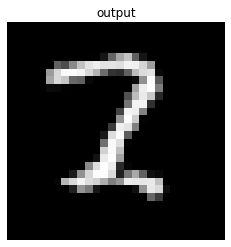

In [15]:
model = torch.load("generator100.pt", map_location=device)
inputs = torch.from_numpy(np.random.normal(size=(1, 100)).astype(np.float32)).to(device)

pred = model(inputs)
pred = pred.cpu().detach().numpy()[0].transpose(1, 2, 0)

display_image(pred, 'output', 'gray')

## 5. Testiranje nevronske mreže

Generira se 25 vektorjev dolžine 100, sledi pa nalaganje vseh shranjenih modelov generatorjev in prikaz 25 generiranih slik z istimi semeni.

GENERATOR PO 1 EPOHAH
PODATKI O ZBIRKI SLIK
IME ZBIRKE: MNIST
ŠTEVILO SLIK: 25
ŠIRINA SLIK: 28
VIŠINA SLIK: 28
ŠTEVILO KANALOV SLIK: 1
PRIMERI SLIK:
GENERATOR PO 10 EPOHAH
PODATKI O ZBIRKI SLIK
IME ZBIRKE: MNIST
ŠTEVILO SLIK: 25
ŠIRINA SLIK: 28
VIŠINA SLIK: 28
ŠTEVILO KANALOV SLIK: 1
PRIMERI SLIK:
GENERATOR PO 20 EPOHAH
PODATKI O ZBIRKI SLIK
IME ZBIRKE: MNIST
ŠTEVILO SLIK: 25
ŠIRINA SLIK: 28
VIŠINA SLIK: 28
ŠTEVILO KANALOV SLIK: 1
PRIMERI SLIK:
GENERATOR PO 30 EPOHAH
PODATKI O ZBIRKI SLIK
IME ZBIRKE: MNIST
ŠTEVILO SLIK: 25
ŠIRINA SLIK: 28
VIŠINA SLIK: 28
ŠTEVILO KANALOV SLIK: 1
PRIMERI SLIK:
GENERATOR PO 40 EPOHAH
PODATKI O ZBIRKI SLIK
IME ZBIRKE: MNIST
ŠTEVILO SLIK: 25
ŠIRINA SLIK: 28
VIŠINA SLIK: 28
ŠTEVILO KANALOV SLIK: 1
PRIMERI SLIK:
GENERATOR PO 50 EPOHAH
PODATKI O ZBIRKI SLIK
IME ZBIRKE: MNIST
ŠTEVILO SLIK: 25
ŠIRINA SLIK: 28
VIŠINA SLIK: 28
ŠTEVILO KANALOV SLIK: 1
PRIMERI SLIK:
GENERATOR PO 60 EPOHAH
PODATKI O ZBIRKI SLIK
IME ZBIRKE: MNIST
ŠTEVILO SLIK: 25
ŠIRINA SLIK: 28
VIŠIN

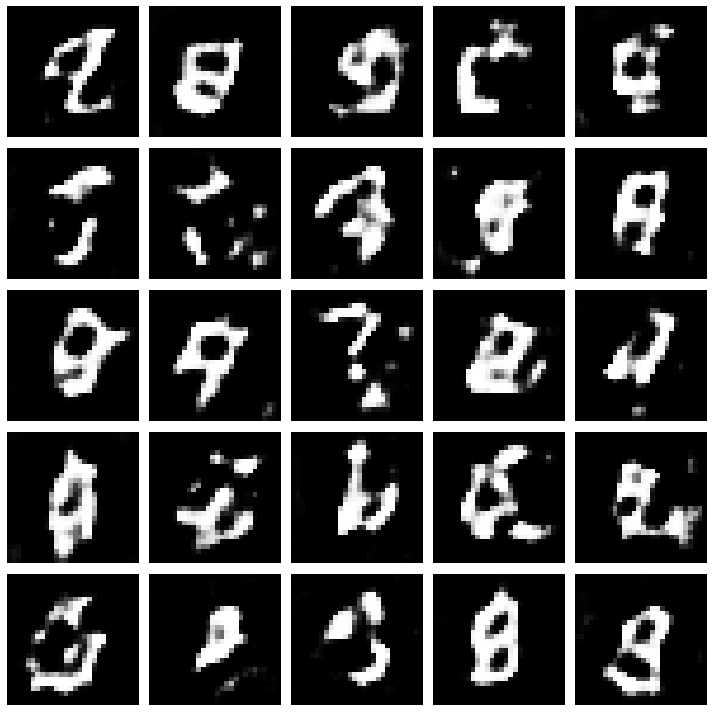

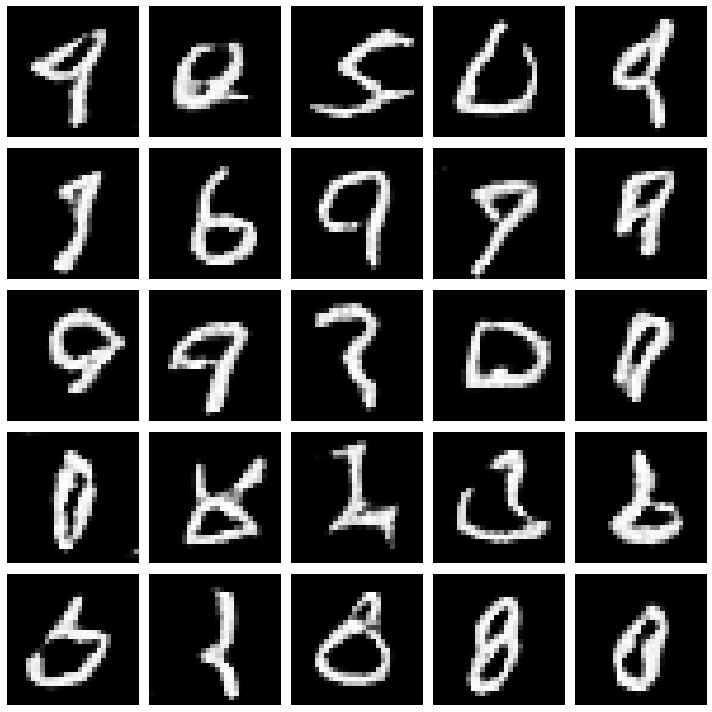

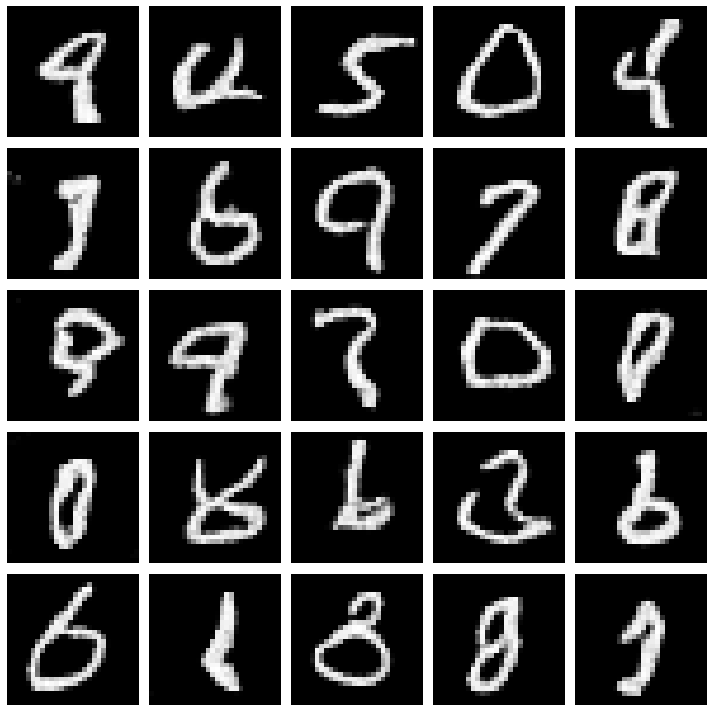

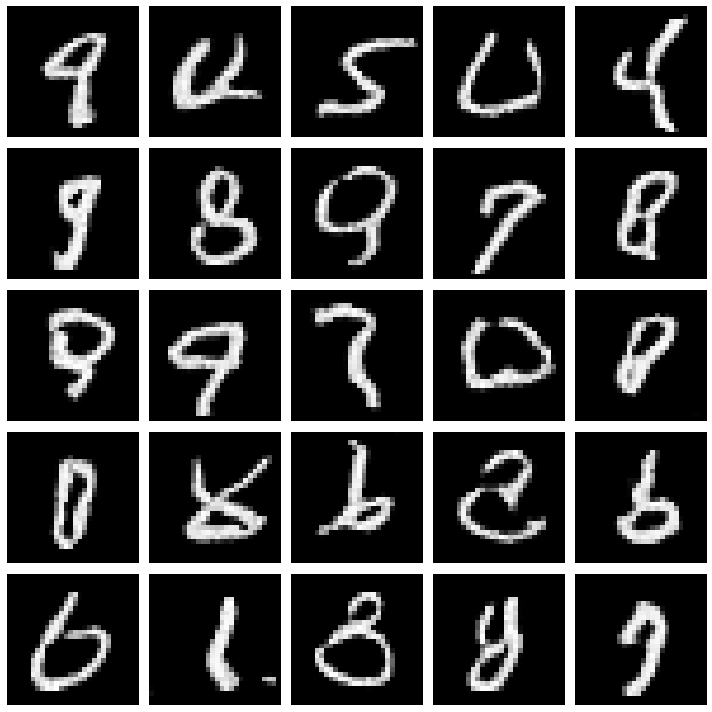

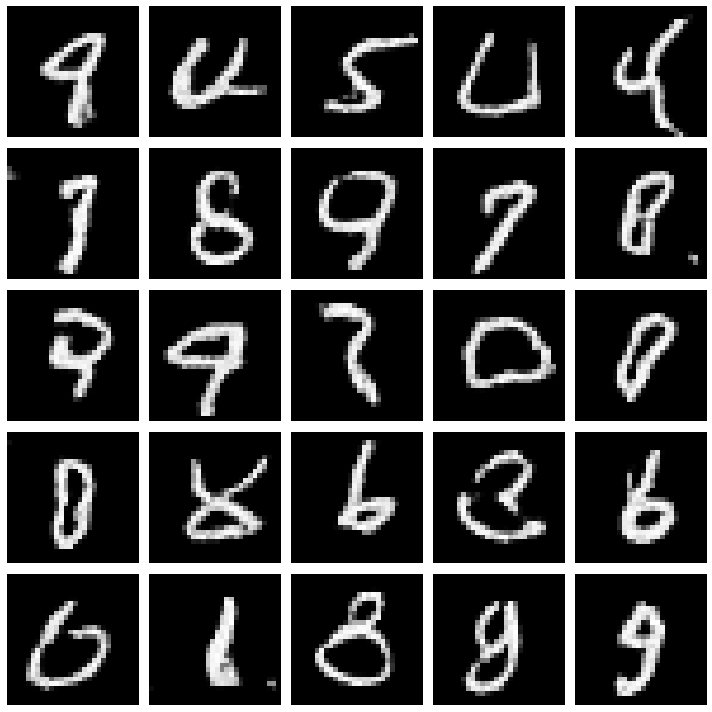

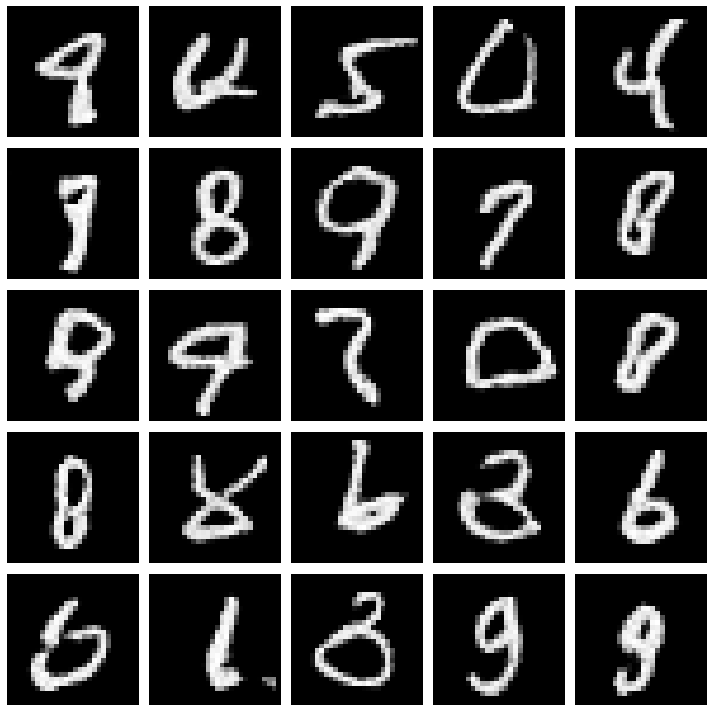

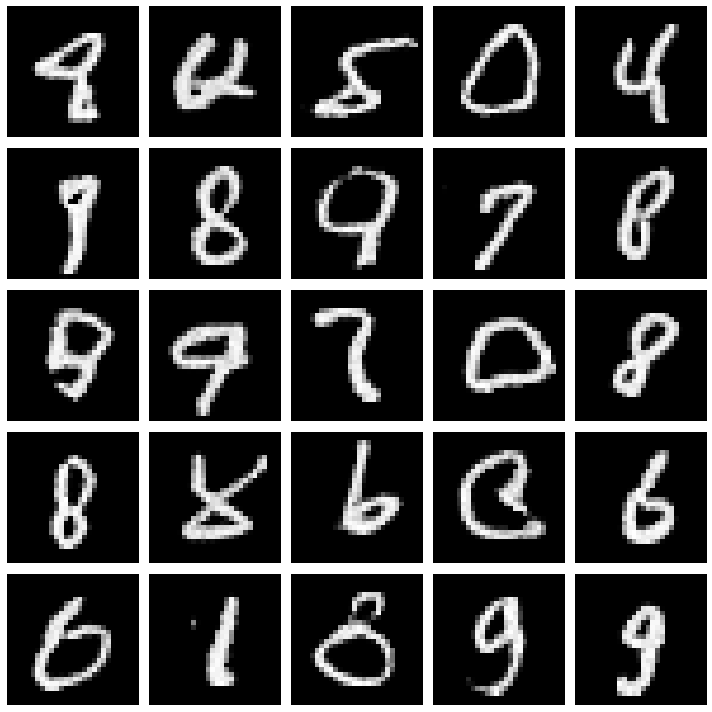

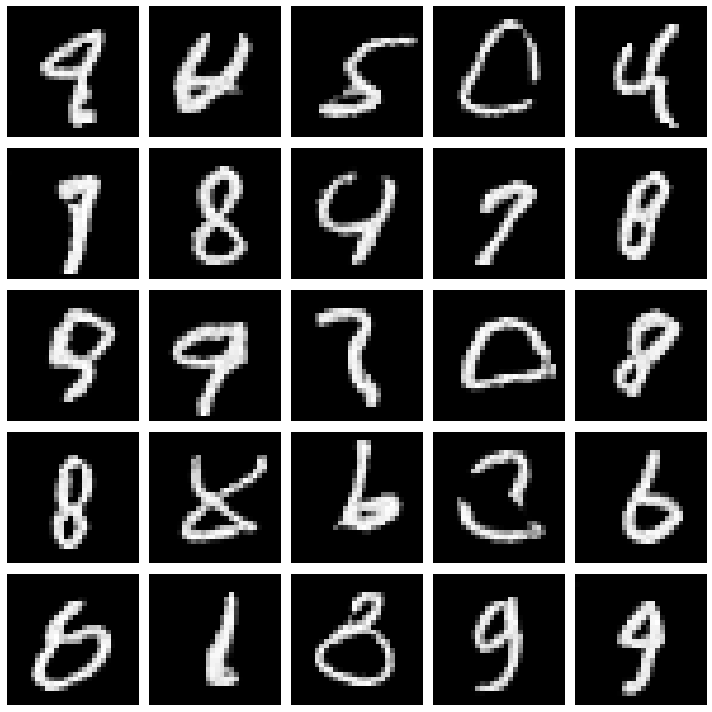

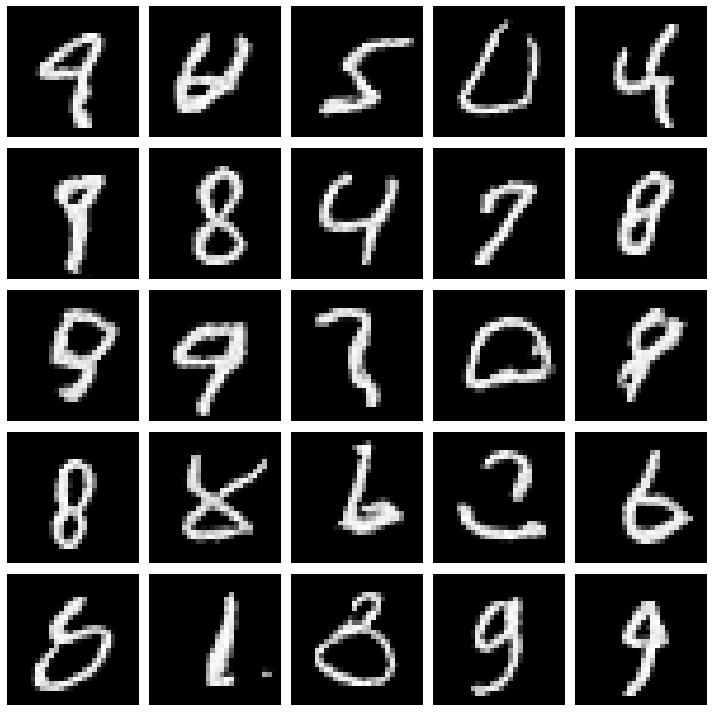

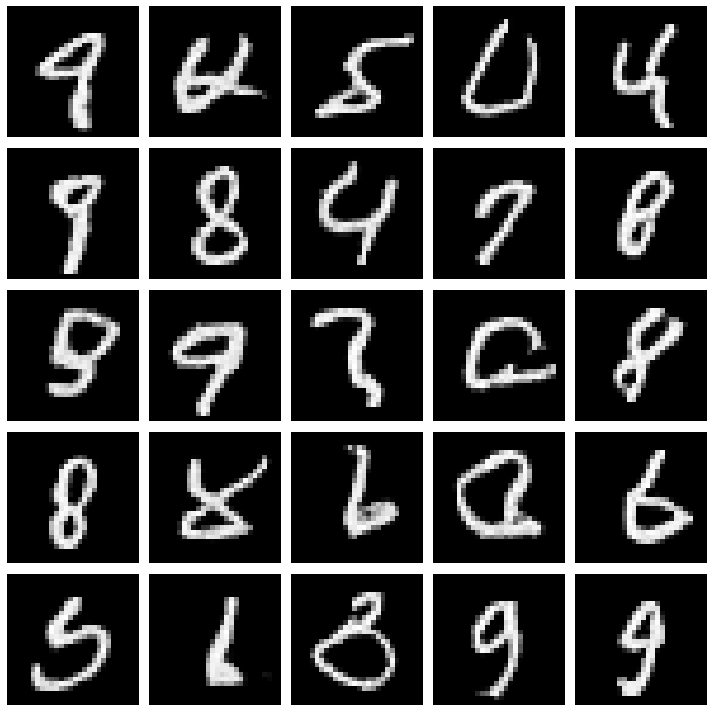

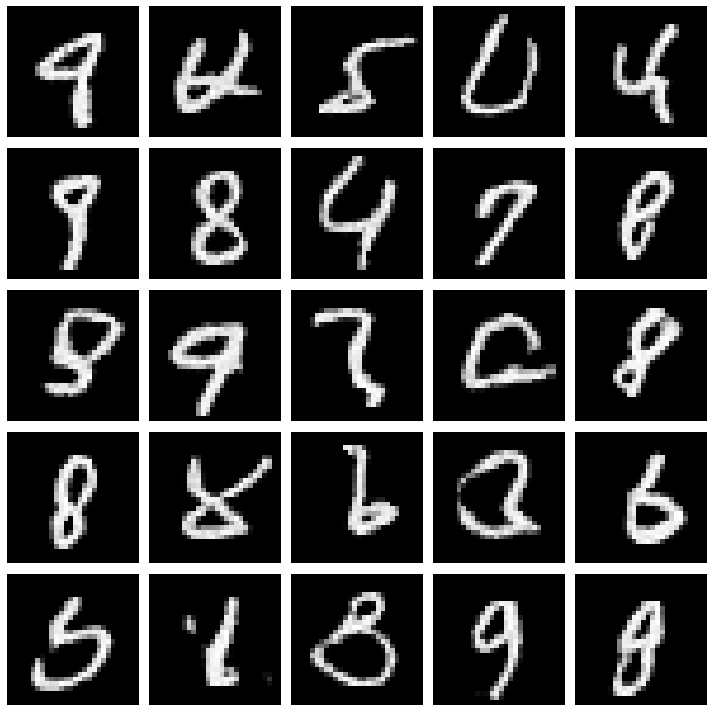

In [16]:
generator_epochs = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
inputs = np.random.normal(size=(25, 100)).astype(np.float32)

for generator_epoch in generator_epochs:
  generated_images = []
  model = torch.load(f"generator{generator_epoch}.pt", map_location=device)

  for i in range(25):
    pred = model(torch.from_numpy(inputs[i]).to(device))
    pred = pred.cpu().detach().numpy()[0].transpose(1, 2, 0)
    generated_images.append(pred)

  generated_images = np.asarray(generated_images)
  print("==================================")
  print(f"GENERATOR PO {generator_epoch} EPOHAH")
  print("==================================")
  print_dataset_info(np.array(generated_images))